# Obdelava podatkov o Evroviziji

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pylab as py 
import statsmodels.api as sm
from scipy import stats

pd.options.display.max_rows = 10
%matplotlib inline

bdp = pd.read_csv(os.path.join('podatki', 'bdp.csv'))
meje = pd.read_csv(os.path.join('podatki', 'meje.csv'))
glasovi = pd.read_csv(os.path.join('podatki', 'esc.csv'), sep=';')
uvrstitve = pd.read_csv(os.path.join('podatki', 'uvrstitve.csv'))

Najprej bom uredil tabelo glasovi, da pomečem proč nepomembne stolpce in preimenujem indekse.

In [2]:
glasovi = glasovi.drop(columns=['Edition', '(semi-) final', 'Jury or Televoting', 'Duplicate'])
glasovi = glasovi.rename(columns={'Year': 'leto', 'From country': 'od države', 'To country': 'državi', 'Points      ' : 'točke'})

Zdaj imam vse tabele pripravljene.

## Analiza uspeha posameznih držav

Zanimalo me bo, če so vse države približno enako uspešne, če obstaja kakšen vzorec,...

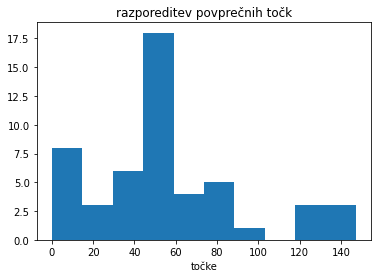

In [206]:
uvrstitve_po_državah = uvrstitve.groupby('država').mean()
točke = uvrstitve_po_državah['točke'].to_numpy()

plt.hist(točke)
plt.title('razporeditev povprečnih točk')
plt.xlabel('točke')
plt.show()

Največ držav doseže povprečno okoli 50 točk. 

Histogram spominja na normalno porazdelitev. Narišmo najbolje prilegajočo se krivuljo.

Text(0.5, 0, 'točke')

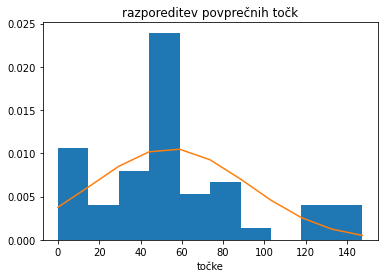

In [207]:
_, bins, _ = plt.hist(točke, density=1)
mu, sigma = scipy.stats.norm.fit(točke)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.title('razporeditev povprečnih točk')
plt.xlabel('točke')

Normalno porazdelitev bom podrobneje testiral na dva načina:

1. #### Q-Q test

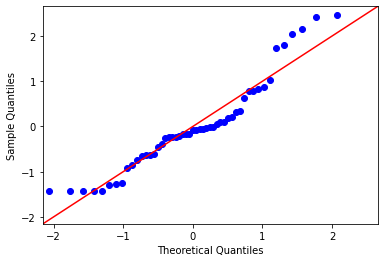

In [189]:
qqplot = sm.qqplot(točke, line='45', fit=True)

Če bi podatki bili normalno porazdeljeni, bi se prilegali rdeči črti. Videti je, da najbolj odstopajo skrajno levo in desno. To pomeni, da je mojih podatkov več v ekstremnih vrednostih, kot bi jih bilo, če bi bila distribucija normalna.

2. #### Shapiro–Wilk test

In [193]:
shapiro_test = stats.shapiro(y)
p = shapiro_test.pvalue
print(p)

0.002811499172821641


Majhno odstopanje od normalne porazdelitve pomeni veliko verjetnostno vrednost ali p-vrednost.
Veliko odstopanje ima tako nizko p-vrednost.

Če je p manjše od 0,05, ne verjamemo, da gre za normalno zarporeditev.

Za naše podatke velja `p = 0.002811499172821641`.

## Povezava uspeha in bdp

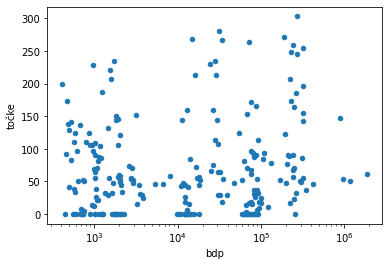

In [209]:
bdp_in_uvrstitve = pd.merge(bdp, uvrstitve).drop(columns='leto')
povprečja_točk_po_bdp = bdp_in_uvrstitve.groupby('bdp', as_index=False).mean()

povprečja_točk_po_bdp.plot.scatter(x = 'bdp', y = 'točke').set_xscale('log')

Iz točk si težko predstavljamo korelacijo, zato poskušajmo podatke aproksimirati s polinomi.

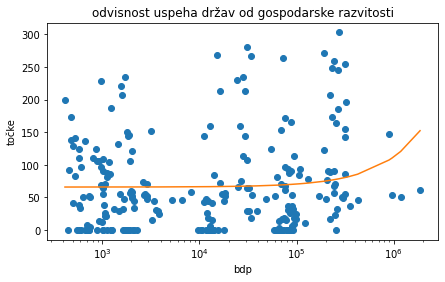

In [4]:
import scipy.optimize as opt

def linearni_polinom(x, a, b):
    return a * x + b

def prilegajoč_se_polinom(polinom):
    koeficienti, _ = opt.curve_fit(polinom, povprečja_točk_po_bdp['bdp'], povprečja_točk_po_bdp['točke'])
    polinom = polinom(povprečja_točk_po_bdp['bdp'], *koeficienti)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(povprečja_točk_po_bdp['bdp'], povprečja_točk_po_bdp['točke'], 'o')
    ax.plot(povprečja_točk_po_bdp['bdp'], polinom)

    ax.set_xscale('log')
    ax.set_xlabel('bdp')
    ax.set_ylabel('točke')
    ax.set_title('odvisnost uspeha držav od gospodarske razvitosti')
    
prilegajoč_se_polinom(linearni_polinom)

Zdi se, da velja, da so razvitejše države uspešnejše. Aproksimirajmo namesto z linearnim polinomom še s polinomom višje stopnje.

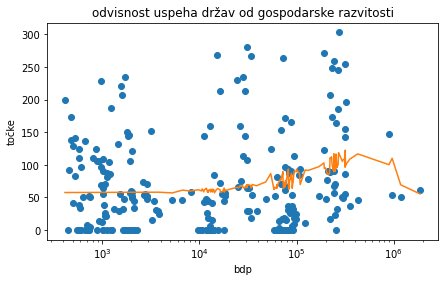

In [5]:
def polinom_visje_stopnje(x, a, b, c, d, e, f):
    return a * x ** 5 + b * x ** 4 + c * x ** 3 + d * x ** 2 + e * x + f

prilegajoč_se_polinom(polinom_visje_stopnje)

Krivulja je načeloma naraščujoča. Izpostavil bi desni del, kjer pade. Poglejmo, zaradi katerih držav se to zgodi (to so tiste z največjim bdp).

In [6]:
države = bdp_in_uvrstitve.groupby('država').mean()
države_ki_kvarijo_krivuljo = države[države.bdp > 9 ** 6]
države_ki_kvarijo_krivuljo

,bdp,točke
država,,
France,1175737.0,51.346154
Germany,1859310.0,62.000000
Italy,891770.0,147.400000
United Kingdom,960428.0,53.730769


Vidimo, da so te države Francija, Nemčija in Velika Britanija. Zanimivo, da se te države izkažejo nesorazmerno svoji gospodarski moči (če bi bila korelacija linearna), čeprav imajo od leta 2000 naprej avtomatsko vstopnico v finale.

Poglejmo si še, katere druge države najbolj odstopajo od linearne aproksimacije.

In [7]:
države['razmerje'] = države.točke / države.bdp
povprečno_razmerje = države.razmerje.mean()

države['odstopanje'] = države.razmerje - povprečno_razmerje
države.sort_values('odstopanje')

,bdp,točke,razmerje,odstopanje
država,,,,
Andorra,1.013000e+03,0.000000,0.000000,-0.012562
Monaco,2.263000e+03,0.000000,0.000000,-0.012562
Germany,1.859310e+06,62.000000,0.000033,-0.012529
France,1.175737e+06,51.346154,0.000044,-0.012518
United Kingdom,9.604280e+05,53.730769,0.000056,-0.012506
...,...,...,...,...
Moldova,1.107067e+03,61.000000,0.055101,0.042538
Bosnia & Herzegovina,1.048944e+03,67.500000,0.064350,0.051788
Azerbaijan,1.809167e+03,120.000000,0.066329,0.053767


K tem podatkom bi dodal le še opombo, da sta Andora in Monako le nekajkrat sodelovala in nikoli prišla v finale. Po drugi strani je zanimivo, da so najuspešnejše države po tem kriteriju ravno Kavkaške države.

## Povezava podeljenih točk in geografske bližine


In [211]:
glasovi

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...
49827,2019,f,2019f,J,Belarus,Greece,3,NaN
49828,2019,f,2019f,J,Belarus,Germany,0,NaN
49829,2019,f,2019f,J,Belarus,Belarus,0,x
49830,2019,f,2019f,J,Belarus,The Netherlands,6,NaN
